
## Importing Libraries
---



In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from os import listdir
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
import shutil
import math
from sklearn import metrics

## Loading Training Dataset

In [2]:
#Get image paths
#pPath='../dataset/ViolaJones/Face'
#nPath='../dataset/ViolaJones/NonFace'
pPath='faces/face.train/train/face'
nPath='faces/face.train/train/non-face'

resizedShape=(19,19)

pImagePath=[]
pImages=[]

count=0
for file in listdir(pPath):
    joinedPath=os.path.join(pPath,file)
    if(os.path.isfile(joinedPath)):
        count+=1
        pImagePath.append(joinedPath)
        img=cv.imread(joinedPath, 0)
        img=cv.resize(img, resizedShape)
        pImages.append(img)
        if(count==2000):
            break

pImages=np.array(pImages)

nImagePath=[]
nImages=[]

count=0
for file in listdir(nPath):
    joinedPath=os.path.join(nPath,file)
    if(os.path.isfile(joinedPath)):
        count+=1
        nImagePath.append(joinedPath)
        img=cv.imread(joinedPath, 0)
        img=cv.resize(img, resizedShape)
        nImages.append(img)
        if(count==2000):
            break

nImages=np.array(nImages)

numPos = np.shape(pImages)[0]
numNeg = np.shape(nImages)[0]

labels=np.concatenate((np.ones(numPos),np.zeros(numNeg)))
images=np.concatenate((pImages, nImages), axis=0)

xTrain=images
yTrain=labels

#xTrain, xTest, yTrain, yTest = train_test_split(images, labels, test_size=0.2)

print(np.shape(xTrain))
#print(np.shape(xTest))
print(np.shape(yTrain))
#print(np.shape(yTest))



(4000, 19, 19)
(4000,)


## Loading Test Dataset

In [3]:
pPath='faces/face.test/test/face'
nPath='faces/face.test/test/non-face'

resizedShape=(19,19)

pImagePath=[]
pImages=[]

count=0
for file in listdir(pPath):
    joinedPath=os.path.join(pPath,file)
    if(os.path.isfile(joinedPath)):
        count+=1
        pImagePath.append(joinedPath)
        img=cv.imread(joinedPath, 0)
        img=cv.resize(img, resizedShape)
        pImages.append(img)
        if(count==500):
            break

pImages=np.array(pImages)

nImagePath=[]
nImages=[]

count=0
for file in listdir(nPath):
    joinedPath=os.path.join(nPath,file)
    if(os.path.isfile(joinedPath)):
        count+=1
        nImagePath.append(joinedPath)
        img=cv.imread(joinedPath, 0)
        img=cv.resize(img, resizedShape)
        nImages.append(img)
        if(count==3000):
            break

nImages=np.array(nImages)

numPos = np.shape(pImages)[0]
numNeg = np.shape(nImages)[0]

labels=np.concatenate((np.ones(numPos),np.zeros(numNeg)))
images=np.concatenate((pImages, nImages), axis=0)

xTest=images
yTest=labels

#xTrain, xTest, yTrain, yTest = train_test_split(images, labels, test_size=0.2)

#print(np.shape(xTrain))
print(np.shape(xTest))
#print(np.shape(yTrain))
print(np.shape(yTest))


(3472, 19, 19)
(3472,)


In [4]:
from sklearn.utils import shuffle
xTrain, yTrain = shuffle(xTrain, yTrain)


In [5]:
xTest, yTest = shuffle(xTest, yTest)

In [6]:
import pickle

with open('xtrain.pickle','wb') as xtrainFile:
     pickle.dump(xTrain, xtrainFile)
        
with open('ytrain.pickle','wb') as ytrainFile:
     pickle.dump(yTrain, ytrainFile)
        
with open('xtest.pickle','wb') as xtestFile:
     pickle.dump(xTest, xtestFile)
        
with open('ytest.pickle','wb') as ytestFile:
     pickle.dump(yTest, ytestFile)

## Visualization of the images

In [7]:
def display(images):
    for img in images:
        #img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        fig = plt.figure(figsize=(1,1))
        #plt.imshow(img)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.show()
        #plt.show()

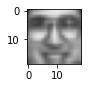

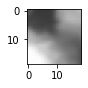

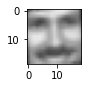

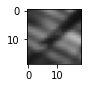

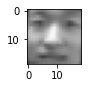

In [8]:
display(xTrain[0:5])

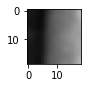

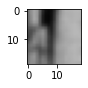

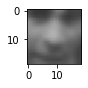

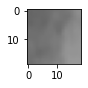

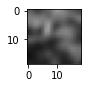

In [9]:
display(xTest[0:5])

## Building features

In [3]:
def buildFeatures():
    windowSize=(19,19)
    minFeatureW=2
    maxFeatureW=19
    minFeatureH=2
    maxFeatureH=19
    features=[]
    featureType=[[1,2],               #2 vertically adjacent (up-down): min width=1, min height=2
                 [2,1],               #2 horizontally adjacent (left-right): min width=2, min height=1
#                  [1,3],               #3 vertically adjacent (3 pixels in a column): min width=1, min height=3
                 [3,1],               #3 horizontally adjacent (3 pixels in a row): min width=3, min height=1
                 [2,2]]               #2H 2V (2X2 pixels): min width=2, min height=2
    
    for feature in featureType:
        minFeatureW=feature[0]
        minFeatureH=feature[1]        
        
        #size of the feature
        for featureW in range(minFeatureW, maxFeatureW+1, feature[0]):
            for featureH in range(minFeatureH, maxFeatureH+1, feature[1]):
                
                #position of the feature
                for row in range(windowSize[0]-featureH+1):
                    for col in range(windowSize[1]-featureW+1):
                        
                        features.append([feature, row, col, featureW, featureH])
        
    return features

In [10]:
features=buildFeatures()

In [11]:
print(len(features))

53130


## Integral Image representation

In [4]:
def getIntegralImg(img):
    rows,cols=np.shape(img)
    s=np.zeros(np.shape(img))
    ii=np.zeros(np.shape(img))
    for i in range(rows):
        for j in range(cols):
            if(i==0):
                s[i,j]=img[i,j]
            else:
                s[i,j]=s[i-1,j]+ img[i,j]
            if(j==0):
                ii[i,j]=s[i,j]
            else:
                ii[i,j]=ii[i,j-1]+s[i,j]
    return ii

In [14]:
sample_image =  np.array([
    [5, 2, 3, 4, 1], 
    [1, 5, 4, 2, 3],
    [2, 2, 1, 3, 4],
    [3, 5, 6, 4, 5],
    [4, 1, 3, 2, 6]])
integralImg=getIntegralImg(sample_image)
print(integralImg)

[[ 5.  7. 10. 14. 15.]
 [ 6. 13. 20. 26. 30.]
 [ 8. 17. 25. 34. 42.]
 [11. 25. 39. 52. 65.]
 [15. 30. 47. 62. 81.]]


## Evaluating and Computing different features

In [5]:
def getSum(integralImg, startRow, startCol, width, height):

    endRow = startRow+height-1
    endCol = startCol+width-1

    val=integralImg[endRow, endCol]        

    if(startCol!=0):
        val-=integralImg[endRow, startCol-1]
    elif(startRow!=0):
        val-=integralImg[startRow-1, endCol]

    if(startCol!=0 and startRow!=0):
        val+=integralImg[startRow-1, endCol-1]
    
    return val
    
def evaluateFeature(img, feature):
    featureType, row, col, featureW, featureH = feature
    
    # width and height of one part of the feature
    width=int(featureW/featureType[0])
    height=int(featureH/featureType[1])

    white=0
    black=0
    
    if(featureType==[1,2]):                                               #B
        black += getSum(img, row, col, width, height)                     #W
        white += getSum(img, row+height, col, width, height)

    elif(featureType==[2,1]):                                            #WB
        white += getSum(img, row, col, width, height)
        black += getSum(img, row, col+width , width, height)

    elif(featureType==[3,1]):                                           #WBW
        white += getSum(img, row, col, width, height)
        black += getSum(img, row, col+width, width, height)
        white += getSum(img, row, col+2*width, width, height)

    elif(featureType==[2,2]):                                             #WB
        white += getSum(img, row, col, width, height)                     #BW
        white += getSum(img, row+height, col+width, width, height)
        black += getSum(img, row, col+width, width, height)
        black += getSum(img, row+height, col, width, height)
        
    return black-white

def computeFeatureValues(images, features):
    numImages=np.shape(images)[0]
    
    res=np.zeros((0, len(features)))
    for j in range(numImages):
        temp=[]
        img=getIntegralImg(images[j])
        for i in range(len(features)):
            feature = features[i]
            featureVal = evaluateFeature(img, feature)
            temp.append(featureVal)
        res = np.hstack((res.reshape(len(temp),-1),np.array(temp).reshape(len(temp),-1)))
    return res

## Computations of the feature values

In [16]:
featureVals = computeFeatureValues(xTrain,features)

In [17]:
print(featureVals.shape)

(53130, 4000)


In [18]:
with open('featureValues.pickle','wb') as featureValuesFile:
     pickle.dump(featureVals, featureValuesFile)

## Select Best Features

In [20]:
bestFeatureIndices = SelectPercentile(f_classif, percentile=10).fit(featureVals.T, yTrain).get_support(indices=True)

In [21]:
print(np.shape(bestFeatureIndices))

(5313,)


In [22]:
featureVals = np.take(featureVals, bestFeatureIndices, axis=0)
selectedFeatures = np.take(features, bestFeatureIndices, axis=0)

/home/aditi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
with open('selectedFeatures.pickle','wb') as file:
     pickle.dump(selectedFeatures, file)
        
with open('selectedFeatureVals.pickle','wb') as file:
     pickle.dump(featureVals, file)

## Train the weak classifiers

In [6]:
#Called for each type of feature
def getPolarityThreshold(weights,labels,featureVal): 
    '''
    weights: weights corresponding to each of the training images
    labels: labels of the training images
    featureVal: List of values computed for the feature on each of the training image

    returns pol, th
    polarity: polarity for the feature
    th: threshold for the feature
    '''
    sortedFeat = sorted(zip(featureVal,weights,labels),key=lambda x:x[0])
    totalPosWt = np.sum(weights[np.where(labels==1)[0]])
    totalNegWt = np.sum(weights[np.where(labels==0)[0]])

    curNegWt = curPosWt = polarity = posMinusNegCount = th = 0
    minErr = np.inf
   
    for val, weight, label in sortedFeat:
        err1=curNegWt + totalPosWt - curPosWt      #when features below current feature are assigned +ve label and above ones are assigned -ve label
        err2=curPosWt + totalNegWt - curNegWt
        err = min(err1, err2)
        if err < minErr:
            if(err1<err2):
                polarity=1                 #so that less than threshold are assigned +ve label using p*featureVal<p*th
            else:
                polarity=-1                #greater than polarity are assigned +ve

            minErr = err
            th = val

        if label==1:
            posMinusNegCount += 1
            curPosWt += weight
        else:
            posMinusNegCount -= 1
            curNegWt += weight
            
    return [polarity,th]


def get_weak_classifier(labels, feature_vals, T=10, removedImgIdx=[], selectedFeatures=[], prevWeakClf=[]):
    '''
    INPUTS
    labels: labels of the images
    featureVals: array of shape (num of Features X num of images); stores value of each feature computed on each image
    T: number of weak classifiers desired
    
    OUTPUTS
    
    '''

    selected = selectedFeatures
    #initialize weights
    weights = np.zeros(len(labels))

    posImgIdx = np.where(labels==1)[0]
    weights[posImgIdx] = 1/(2*len(posImgIdx))

    negImgIdx = np.where(labels==0)[0]
    weights[negImgIdx] = 1/(2*len(negImgIdx))

    weak_classifiers = []
    alphas = []

    startIter=0

    if(prevWeakClf!=[]):
        clfs, weights = prevWeakClf
        for clf in clfs:
            _, _, idx, alpha = clf
            selected.append(idx)
            alphas.append(alpha)

        weak_classifiers=clfs
        
        startIter=len(weak_classifiers)
    
    #Get weak classifiers
    #For each iteration - select classifier with min error -> update weights -> normalize weights
    for t in range(startIter, T): 
        min_err = np.inf
        pred_t = None
        min_ind = 0
        p_t = 0
        
        weights *= 1. / np.sum(weights)

        #for each feature train a classifier
        for i in range(len(feature_vals)):
            if i not in selected:
                feature_val_i = feature_vals[i]
                feature_val_i = np.delete(feature_val_i, removedImgIdx, axis=0)
                p,th = getPolarityThreshold(weights,labels,feature_val_i)
                
                pred = np.zeros(len(feature_val_i))
                pred[np.where(p*feature_val_i < p*th)[0]] = 1 
                
                err = np.sum(weights[np.where(pred!=labels)[0]])
                if err<min_err:
                    min_err = err.copy()
                    pred_t = pred.copy()
                    p_t = p
                    th_t = th
                    min_ind = i
        
        selected.append(min_ind)
        beta = min_err/(1-min_err)
        
        ind = np.where(pred_t==labels)[0]
        weights[ind] = weights[ind]*beta
        print(f"Iter {t}: \nCorrect predictions: {len(ind)}\n")
        
        alphas.append(math.log((1/beta)))
        weak_classifiers.append([p_t,th_t,min_ind,alphas[-1]]) #np.vstack((weak_classifiers,(pred_t*alphas[-1])))
           
    print("Alpha values:", alphas)
    
    th = np.sum(np.array(alphas))/2
    
    return [weak_classifiers,th, weights]    
        

In [13]:
weak_classifiers,th, weights = get_weak_classifier(yTrain,featureVals)

Iter 0: 
Correct predictions: 3483

Iter 1: 
Correct predictions: 3390

Iter 2: 
Correct predictions: 3163

Iter 3: 
Correct predictions: 3169

Iter 4: 
Correct predictions: 2954

Iter 5: 
Correct predictions: 3224

Iter 6: 
Correct predictions: 2102

Iter 7: 
Correct predictions: 3239

Iter 8: 
Correct predictions: 1308

Iter 9: 
Correct predictions: 2781

Alpha values: [1.9076063958575729, 1.5232479107353605, 1.036068488626131, 0.9082941553770388, 0.8187616738739544, 0.9297064343163118, 0.8141409358674889, 0.8341703193832662, 0.7665302504054414, 0.7649563267023524]


## Train the strong classifier

In [14]:
def strong_classifier(weak_classifiers, alpha_th, images,features, integral=False):
    '''
    INPUTS
    images: training images
    labels: labels of the images
    feature: array of shape (num of Features X num of images); stores value of each feature computed on each image
    alpha_th: hreshold of the feature
    
    OUTPUTS
    Returns the prediction whether it is a face or not
    
    '''
    h = np.zeros(len(images))
    for clf in weak_classifiers:
        p,th,i,alpha = clf
        feature = get_feature_val(images, features[i], integral)
        h[np.where(p*feature < p*th)[0]] += alpha
    
    pred = np.zeros(len(images))
    pred[np.where(h>=alpha_th)] = 1
    
    return pred


In [15]:
def get_feature_val(images,feature, integral=False):
    f = []
    for img in images:
        if(integral):
            f.append(evaluateFeature(img,feature))
        else:
            f.append(evaluateFeature(getIntegralImg(img),feature))
    
    return np.array(f)

### Prediction of the training dataset

In [16]:
y_pred_train = strong_classifier(weak_classifiers,th,xTrain,selectedFeatures)

### Metrics for the training dataset


In [17]:
accuracy_train=metrics.accuracy_score(y_pred_train,yTrain)
print("Accuracy score:")
print(accuracy_train)

f1_train=metrics.f1_score(y_pred_train,yTrain,average='weighted')
print("F1-Score:")
print(f1_train)

report_train=metrics.classification_report(y_pred_train,yTrain)
print("Classification Report:")
print(report_train)

confusion_train=metrics.confusion_matrix(y_pred_train,yTrain)
print("Confusion Matrix:")
print(confusion_train)

Accuracy score:
0.94375
F1-Score:
0.9437630846836318
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1939
         1.0       0.96      0.93      0.94      2061

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

Confusion Matrix:
[[1857   82]
 [ 143 1918]]


### Predictions about the test dataset 


In [18]:
y_pred_test =  strong_classifier(weak_classifiers,th,xTest,selectedFeatures)

### Metrics for the test dataset

Accuracy Score:
0.868663594470046
F1-score:
0.8771013257085523
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      3122
         1.0       0.39      0.52      0.45       350

    accuracy                           0.87      3472
   macro avg       0.67      0.72      0.69      3472
weighted avg       0.89      0.87      0.88      3472

Confusion Matrix:
[[2833  289]
 [ 167  183]]
+------------------+--------------------+--------------------+
|     Metrics      |  Training Dataset  |    Test Dataset    |
+------------------+--------------------+--------------------+
|  Accuracy score  |      0.94375       | 0.868663594470046  |
|     f1_score     | 0.9437630846836318 | 0.8771013257085523 |
| confusion matrix |    [[1857   82]    |    [[2833  289]    |
|                  |    [ 143 1918]]    |    [ 167  183]]    |
+------------------+--------------------+--------------------+


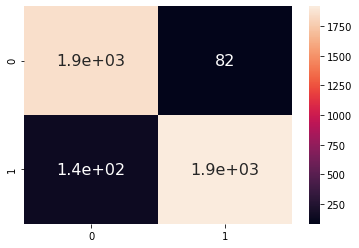

In [19]:
accuracy_test=metrics.accuracy_score(y_pred_test,yTest)
print("Accuracy Score:")
print(accuracy_test)

f1_test=metrics.f1_score(y_pred_test,yTest,average='weighted')
print("F1-score:")
print(f1_test)

classification_test=metrics.classification_report(y_pred_test,yTest)
print("Classification Report:")
print(classification_test)

confusion_test=metrics.confusion_matrix(y_pred_test,yTest)
print("Confusion Matrix:")
print(confusion_test)

from prettytable import PrettyTable
opt=['Accuracy score','f1_score','confusion matrix']
train=[accuracy_train,f1_train,confusion_train]
test=[accuracy_test,f1_test,confusion_test]
t=PrettyTable(['Metrics','Training Dataset','Test Dataset'])
for i in range(3):
    main=opt[i]
    col1=train[i]
    col2=test[i]
    t.add_row([main,col1,col2])
print(t)

import seaborn as sns
sns.heatmap(confusion_train, annot=True, annot_kws={"size": 16}) 
plt.show()

## Adaboost Training

### Load Dataset and corresponding featureVals

In [12]:
import pickle
file = open('xtrain.pickle', 'rb')
xTrain = pickle.load(file)
file.close()

file = open('ytrain.pickle', 'rb')
yTrain = pickle.load(file)
file.close()

file = open('xtest.pickle', 'rb')
xTest = pickle.load(file)
file.close()

file = open('ytest.pickle', 'rb')
yTest = pickle.load(file)
file.close()

file = open('featureValues.pickle', 'rb')
featureVals = pickle.load(file)
file.close()

bestFeatureIndices = SelectPercentile(f_classif, percentile=10).fit(featureVals.T, yTrain).get_support(indices=True)
featureVals = np.take(featureVals, bestFeatureIndices, axis=0)
selectedFeatures = np.take(features, bestFeatureIndices, axis=0)

/home/aditi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [20]:
def getAdaboostClassifier(yTrain, T, removedImgIdx, selectedFeatureIdx, prevWeakClf=[]):

    file = open('selectedFeatureVals.pickle', 'rb')
    featureVals = pickle.load(file)
    file.close()

    weak_classifiers, th, weights = get_weak_classifier(yTrain, featureVals, T, removedImgIdx, selectedFeatureIdx, prevWeakClf)
    return weak_classifiers, th, weights


In [21]:
xTrainInt=np.empty(np.shape(xTrain))
xTestInt=np.empty(np.shape(xTest))

for idx,img in enumerate(xTrain):
    xTrainInt[idx]=getIntegralImg(img)

for idx,img in enumerate(xTest):
    xTestInt[idx]=getIntegralImg(img)

In [22]:
def getCascadedClf(xTrainInt, yTrain, xTestInt, yTest, selectedFeatures, maxStages=3):
    tpr=0.5
    fpr=0.6
    tprFinal=0.6
    fprFinal=0.08
    
    tprList=np.ones(maxStages+1, dtype='float')
    fprList=np.ones(maxStages+1, dtype='float')
    numFeat=np.zeros(maxStages+1, dtype='int')
    
    xTrainCur=xTrainInt.copy()
    yTrainCur=yTrain.copy()

    xTestCur=xTestInt.copy()
    yTestCur=yTest.copy()

    cascadedClf=[]
    alphaTh=[]
    i=0
    usedFeatureIdx=[]
    removedIdx=[]
    
    while((fprList[i]>fprFinal or tprList[i]<tprFinal) and i<maxStages):
        prevtpr=tprList[i]
        prevfpr=fprList[i]
        i+=1
        tprList[i]=prevtpr
        fprList[i]=prevfpr
        print("---------------------------------------------")
        print("Stage: ", i)
        prevWeakClf=[]
        
        while((fprList[i]>fpr*prevfpr or tprList[i]<tpr*prevtpr) and numFeat[i]<10):
            numFeat[i]+=1
            print("Number of Features in Classifier: ", numFeat[i])
            weakClf, th, weights = getAdaboostClassifier(yTrainCur, numFeat[i], removedIdx, usedFeatureIdx, prevWeakClf)
            yPredTest = strong_classifier(weakClf, th, xTestCur, selectedFeatures, integral=True)
            TP = len(np.where((yPredTest==1) & (yTestCur==1))[0])
            FP = len(np.where((yPredTest==1) & (yTestCur==0))[0])
            TN = len(np.where((yPredTest==0) & (yTestCur==0))[0])
            FN = len(np.where((yPredTest==0) & (yTestCur==1))[0])
            
            tprList[i] = TP/(TP+FN)
            fprList[i] = FP/(FP+TN)
            print(f'curtpr: {tprList[i]}, curfpr: {fprList[i]}\n\n')
            prevWeakClf= [weakClf, weights]
            
        removedIdx = testPrevCascadeClf(xTrainCur, yTrainCur, cascadedClf, alphaTh, selectedFeatures, removedIdx)
        xTrainCur=np.delete(xTrainInt,removedIdx, axis=0)
        yTrainCur=np.delete(yTrain,removedIdx, axis=0)
        cascadedClf.append(weakClf)
#         for feature in weakClf:
#             usedFeatureIdx.append(feature[2])
        alphaTh.append(th)
    
    return cascadedClf

def testPrevCascadeClf(xInt, y, clfs, alphaThs, selectedFeatures, removedIdx):
    clfCorrect=False
    #remove if rejected (predicted as nonface i.e. ypred=0) by any one of the classifiers
    #new neglist will contain negative examples classified positive (False Positives)
    removeIdx=set(removedIdx)
    negIdx=np.where(y==0)[0]
    
    for idx in negIdx:
        img = xInt[idx]
        img=np.expand_dims(img, axis=0)
#         print(np.shape(img))
        for clf, th in zip(clfs,alphaThs):
            yPred = strong_classifier(clf, th, img, selectedFeatures, integral=True)
            if(yPred==0):
                clfCorrect=True
                break
        if(clfCorrect==True):
            clfCorrect=False
            removeIdx.add(idx)
            
    return list(removeIdx)

In [23]:
file = open('selectedFeatures.pickle', 'rb')
selectedFeatures = pickle.load(file)
file.close()

cascadedClf = getCascadedClf(xTrainInt, yTrain, xTestInt, yTest, selectedFeatures, maxStages=3)

---------------------------------------------
Stage:  1
Number of Features in Classifier:  1
Iter 0: 
Correct predictions: 3483

Alpha values: [1.9076063958575729]
curtpr: 0.5911016949152542, curfpr: 0.225


---------------------------------------------
Stage:  2
Number of Features in Classifier:  1
Iter 0: 
Correct predictions: 3477

Alpha values: [1.8943436679429393]
curtpr: 0.5741525423728814, curfpr: 0.218


Number of Features in Classifier:  2
Iter 1: 
Correct predictions: 3390

Alpha values: [1.8943436679429393, 1.5308058640562918]
curtpr: 0.5741525423728814, curfpr: 0.218


Number of Features in Classifier:  3
Iter 2: 
Correct predictions: 3163

Alpha values: [1.8943436679429393, 1.5308058640562918, 1.0648743976834303]
curtpr: 0.3453389830508475, curfpr: 0.08433333333333333


---------------------------------------------
Stage:  3
Number of Features in Classifier:  1
Iter 0: 
Correct predictions: 1923

Alpha values: [1.5835842647254739]
curtpr: 0.2584745762711864, curfpr: 0.1076

In [24]:
for strongClf in cascadedClf:
    print(strongClf)

[[1, -1199.0, 1825, 1.9076063958575729]]
[[1, -1166.0, 1781, 1.8943436679429393], [-1, 287.0, 2091, 1.5308058640562918], [-1, 46.0, 3099, 1.0648743976834303]]
[[-1, 264.0, 2068, 1.5835842647254739], [-1, 23.0, 2652, 1.1946141667144061], [1, -90.0, 2217, 0.9570873517475604], [-1, 28.0, 1887, 0.9571920480058106], [-1, 163.0, 1552, 0.956088157363038], [-1, 84.0, 3100, 0.6788744484213923], [-1, -327.0, 4339, 0.6704857150621522], [1, -404.0, 4888, 0.8175223020032063], [1, -137.0, 1809, 0.775546682002781], [-1, 203.0, 2209, 0.8923317668168701]]


In [25]:
def predictCascade(xTestInt, cascadedClf):
#     TP, FN, FP, TN = 0, 0, 0, 0
#     falsePos=[]
    file = open('selectedFeatures.pickle', 'rb')
    selectedFeatures = pickle.load(file)
    file.close()

    yPred=[]
    for img in xTestInt:
        img=np.expand_dims(img, axis=0)
        for strongClf in cascadedClf:
            alphaSum=0
            for clf in strongClf:
                alphaSum+=clf[3]
            alphaTh=0.5*alphaSum
            pred = strong_classifier(strongClf, alphaTh, img, selectedFeatures, integral=True)
            if(pred==0):
                break
        yPred.append(pred)
    return yPred

### Predictions about the training dataset 

In [26]:
y_pred_train=predictCascade(xTrainInt, cascadedClf)

### Metrics for the training dataset

In [27]:
# print(np.sh)
accuracy_train=metrics.accuracy_score(y_pred_train,yTrain)
print("Accuracy score:")
print(accuracy_train)

Accuracy score:
0.9195


In [28]:
f1_train=metrics.f1_score(y_pred_train,yTrain,average='weighted')
print("F1-Score:")
print(f1_train)

F1-Score:
0.9198850939322113


In [29]:
report_train=metrics.classification_report(y_pred_train,yTrain)
print("Classification Report:")
print(report_train)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      2276
         1.0       0.85      0.99      0.91      1724

    accuracy                           0.92      4000
   macro avg       0.92      0.93      0.92      4000
weighted avg       0.93      0.92      0.92      4000



In [30]:
confusion_train=metrics.confusion_matrix(y_pred_train,yTrain)
print("Confusion Matrix:")
print(confusion_train)

Confusion Matrix:
[[1977  299]
 [  23 1701]]


## Predictions about the test dataset 

In [31]:
y_pred_test =  predictCascade(xTestInt, cascadedClf)

## Metrics for the test dataset

In [32]:
from sklearn import metrics
accuracy_test=metrics.accuracy_score(y_pred_test,yTest)
print("Accuracy Score:")
print(accuracy_test)

Accuracy Score:
0.8793202764976958


In [33]:
f1_test=metrics.f1_score(y_pred_test,yTest,average='weighted')
print("F1-score:")
print(f1_test)

F1-score:
0.9120080947004234


In [34]:
classification_test=metrics.classification_report(y_pred_test,yTest)
print("Classification Report:")
print(classification_test)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      3353
         1.0       0.18      0.72      0.29       119

    accuracy                           0.88      3472
   macro avg       0.59      0.80      0.61      3472
weighted avg       0.96      0.88      0.91      3472



In [35]:
confusion_test=metrics.confusion_matrix(y_pred_test,yTest)
print("Confusion Matrix:")
print(confusion_test)

Confusion Matrix:
[[2967  386]
 [  33   86]]


In [36]:
from prettytable import PrettyTable
opt=['Accuracy score','f1_score','confusion matrix']
train=[accuracy_train,f1_train,confusion_train]
test=[accuracy_test,f1_test,confusion_test]
t=PrettyTable(['Metrics','Training Dataset','Test Dataset'])
for i in range(3):
    main=opt[i]
    col1=train[i]
    col2=test[i]
    t.add_row([main,col1,col2])
print(t)

+------------------+--------------------+--------------------+
|     Metrics      |  Training Dataset  |    Test Dataset    |
+------------------+--------------------+--------------------+
|  Accuracy score  |       0.9195       | 0.8793202764976958 |
|     f1_score     | 0.9198850939322113 | 0.9120080947004234 |
| confusion matrix |    [[1977  299]    |    [[2967  386]    |
|                  |    [  23 1701]]    |    [  33   86]]    |
+------------------+--------------------+--------------------+


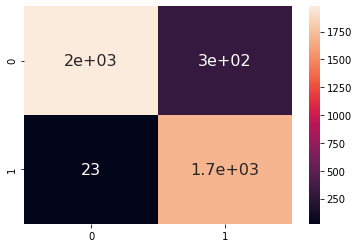

In [37]:
import seaborn as sns
sns.heatmap(confusion_train, annot=True, annot_kws={"size": 16}) 
plt.show()

## T=15


In [38]:
weak_classifiers1,th1, weights = get_weak_classifier(yTrain, featureVals, T=15)

Iter 0: 
Correct predictions: 3477

Iter 1: 
Correct predictions: 3403

Iter 2: 
Correct predictions: 3053

Iter 3: 
Correct predictions: 3049

Iter 4: 
Correct predictions: 3257

Iter 5: 
Correct predictions: 3018

Iter 6: 
Correct predictions: 2105

Iter 7: 
Correct predictions: 2666

Iter 8: 
Correct predictions: 3078

Iter 9: 
Correct predictions: 1289

Iter 10: 
Correct predictions: 3375

Iter 11: 
Correct predictions: 2974

Iter 12: 
Correct predictions: 1526

Iter 13: 
Correct predictions: 2905

Iter 14: 
Correct predictions: 2690

Alpha values: [1.8943436679429393, 1.526931800211508, 0.9974674146078217, 1.037136312671882, 0.915874105496266, 0.7487004356391397, 0.8063364598090215, 0.6752056004912803, 0.7245283871394079, 0.6471656074968896, 0.7011987048581995, 0.6964088885206858, 0.5506671841588914, 0.6230442794589668, 0.5797668462886325]


## Prediction of the training dataset

In [39]:
y_pred_train1 = strong_classifier(weak_classifiers1,th1,xTrain,selectedFeatures)

## Metrics for the training dataset

In [40]:
from sklearn import metrics
accuracy_train1=metrics.accuracy_score(y_pred_train1,yTrain)
print("Accuracy score:")
print(accuracy_train1)

Accuracy score:
0.9555


In [41]:
f1_train1=metrics.f1_score(y_pred_train1,yTrain,average='weighted')
print("F1-Score:")
print(f1_train1)

F1-Score:
0.9555013461657216


In [42]:
report_train1=metrics.classification_report(y_pred_train1,yTrain)
print("Classification Report:")
print(report_train1)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2022
         1.0       0.95      0.96      0.96      1978

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [43]:
confusion_train1=metrics.confusion_matrix(y_pred_train1,yTrain)
print("Confusion Matrix:")
print(confusion_train1)

Confusion Matrix:
[[1922  100]
 [  78 1900]]


## Predictions about the test dataset 

In [44]:
y_pred_test1 =  strong_classifier(weak_classifiers1,th1,xTest,selectedFeatures)

## Metrics for the test dataset

In [45]:
from sklearn import metrics
accuracy_test1=metrics.accuracy_score(y_pred_test1,yTest)
print("Accuracy Score:")
print(accuracy_test1)

Accuracy Score:
0.8758640552995391


In [46]:
f1_test1=metrics.f1_score(y_pred_test1,yTest,average='weighted')
print("F1-score:")
print(f1_test1)

F1-score:
0.8984155588198033


In [47]:
classification_test1=metrics.classification_report(y_pred_test1,yTest)
print("Classification Report:")
print(classification_test1)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      3273
         1.0       0.25      0.60      0.36       199

    accuracy                           0.88      3472
   macro avg       0.61      0.75      0.64      3472
weighted avg       0.93      0.88      0.90      3472



In [48]:
confusion_test1=metrics.confusion_matrix(y_pred_test1,yTest)
print("Confusion Matrix:")
print(confusion_test1)

Confusion Matrix:
[[2921  352]
 [  79  120]]


In [49]:
from prettytable import PrettyTable
opt=['Accuracy score','f1_score','confusion matrix']
train=[accuracy_train1,f1_train1,confusion_train1]
test=[accuracy_test1,f1_test1,confusion_test1]
t=PrettyTable(['Metrics for T=50','Training Dataset','Test Dataset'])
for i in range(3):
    main=opt[i]
    col1=train[i]
    col2=test[i]
    t.add_row([main,col1,col2])
print(t)

+------------------+--------------------+--------------------+
| Metrics for T=50 |  Training Dataset  |    Test Dataset    |
+------------------+--------------------+--------------------+
|  Accuracy score  |       0.9555       | 0.8758640552995391 |
|     f1_score     | 0.9555013461657216 | 0.8984155588198033 |
| confusion matrix |    [[1922  100]    |    [[2921  352]    |
|                  |    [  78 1900]]    |    [  79  120]]    |
+------------------+--------------------+--------------------+


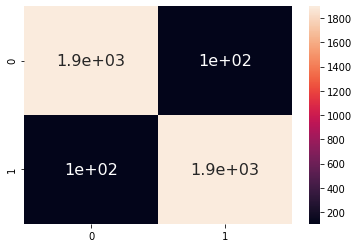

In [175]:
import seaborn as sns
sns.heatmap(confusion_train1, annot=True, annot_kws={"size": 16}) 
plt.show()

In [1]:
#Train Adaboost classifier
